In [0]:
#import libraries 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, Panel
from bokeh.models.widgets import Tabs

plt.style.use('ggplot')
plt.style.use('seaborn-notebook')
plt.style.use('seaborn-white')


In [41]:
startup = pd.read_csv('https://github.com/yashica95/startup_funding/blob/master/data/datasets_1902_941761_startup_funding.csv', parse_dates=[1])
startup.shape

(3044, 10)

In [42]:
startup.head()

,Sr No,Date dd/mm/yyyy,Startup Name,Industry Vertical,SubVertical,City Location,Investors Name,InvestmentnType,Amount in USD,Remarks
0,1,09/01/2020,BYJU’S,E-Tech,E-learning,Bengaluru,Tiger Global Management,Private Equity Round,"20,00,00,000",NaN
1,2,13/01/2020,Shuttl,Transportation,App based shuttle service,Gurgaon,Susquehanna Growth Equity,Series C,"80,48,394",NaN
2,3,09/01/2020,Mamaearth,E-commerce,Retailer of baby and toddler products,Bengaluru,Sequoia Capital India,Series B,"1,83,58,860",NaN
3,4,02/01/2020,https://www.wealthbucket.in/,FinTech,Online Investment,New Delhi,Vinod Khatumal,Pre-series A,"30,00,000",NaN
4,5,02/01/2020,Fashor,Fashion and Apparel,Embroiled Clothes For Women,Mumbai,Sprout Venture Partners,Seed Round,"18,00,000",NaN


In [0]:
#Understanding our data
#All columns are categorical, except Sr No. - which we can drop since it does not provide any extra information 

startup.drop('Sr No', inplace=True, axis=1)

In [0]:
#let's clean the column names for easy indexing
startup.columns = ['date', 'startup', 'industry','sub_vertical','location','investor','investment_type','amount','remarks' ]



In [0]:
def clean_string(x):
    x = str(x).replace("\\xc2\\xa0","").replace("\\\\xc2\\\\xa0", "").replace("+","").replace(",","").replace("nan", "").replace("Undisclosed","").replace("undisclosed","").replace("unknown","").replace("N/A","")
    if x == '':
        x = '-999'
    return x


#clean all strings in data and remove unnecessary characters 
for col in startup.columns:
    startup[col]= startup[col].apply(lambda x: clean_string(x))

In [46]:
#Find Missing Values
startup.isna().sum()

date               0
startup            0
industry           0
sub_vertical       0
location           0
investor           0
investment_type    0
amount             0
remarks            0
dtype: int64

In [47]:
startup.describe()

,date,startup,industry,sub_vertical,location,investor,investment_type,amount,remarks
count,3044,3044,3044,3044,3044,3044,3044,3044,3044
unique,1035,2457,822,1943,108,2393,56,458,70
top,08/07/2015,Swiggy,Consumer Internet,-999,Bangalore,investors,Private Equity,-999,-999
freq,11,8,941,936,701,41,1356,971,2625


In [48]:
print( f'so we have data of {startup.shape[0]} startups from {startup.date.min()} to {startup.date.max()}')

so we have data of 3044 startups from 01/01/2016 to 31/10/2017


In [0]:
#correct dates to match DD/MM/YYYY format
startup['date'][startup['date']=='05/072018']='05/07/2018'
startup['date'][startup['date']=='01/07/015']='01/07/2015'
startup['date'][startup['date']=='12/05.2015']='12/05/2015'
startup['date'][startup['date']=='13/04.2015']='13/04/2015'
startup['date'][startup['date']=='15/01.2015']='15/01/2015'
startup['date'][startup['date']=='22/01//2015']='22/01/2015'

startup["year"] = pd.to_datetime(startup['date'],format='%d/%m/%Y').dt.year
startup["month"] = pd.to_datetime(startup['date'],format='%d/%m/%Y').dt.month


In [50]:
#Number of fundings per year
startup['year'].value_counts()

2016    993
2015    936
2017    687
2018    310
2019    111
2020      7
Name: year, dtype: int64

# Trend in Number of Fundings

In [0]:
TOOLS = "hover,save,pan,box_zoom,reset,wheel_zoom"
p = figure(
    plot_width=400, 
    plot_height=400,
    tools=TOOLS,
    title='Number of Fundings Received from 2015-2020')
df = pd.DataFrame(startup['year'].value_counts()).reset_index()
p.vbar(x='index', width=0.5, bottom=0,
       top='year', color="#1E90FF", source=df )

hover = p.select(dict(type=HoverTool))
hover.tooltips = [("# of fundings", "@year")]
show(p)


Number of Fundings increased in 2016 but since then, there has been a steady decrease in the number of fundings 

In [0]:
year_month =startup.groupby(['year','month']).agg(['count'])['amount']


In [0]:
#Some Amount values are NaN so we substitute them with -999 for easy handeling of data
startup['amount'] = startup['amount'].apply(lambda x: float(x))
startup['amount'] = startup['amount'] [~np.isnan(startup['amount'] )]
startup['amount']  = startup['amount'] [startup['amount'] !=-999]

In [54]:
#Top 5 startups that got the maximum amount of funding
startup.sort_values(by='amount', ascending=False).head(5)

,date,startup,industry,sub_vertical,location,investor,investment_type,amount,remarks,year,month
60,27/08/2019,Rapido Bike Taxi,Transportation,Bike Taxi,Bengaluru,Westbridge Capital,Series B,3.900000e+09,-999,2019,8
651,11/08/2017,Flipkart,eCommerce,Online Marketplace,Bangalore,Softbank,Private Equity,2.500000e+09,-999,2017,8
966,21/03/2017,Flipkart,eCommerce,ECommerce Marketplace,Bangalore,Microsoft eBay Tencent Holdings,Private Equity,1.400000e+09,-999,2017,3
830,18/05/2017,Paytm,ECommerce,Mobile Wallet & ECommerce platform,Bangalore,SoftBank Group,Private Equity,1.400000e+09,-999,2017,5
31,25/11/2019,Paytm,FinTech,Mobile Wallet,Noida,Vijay Shekhar Sharma,Funding Round,1.000000e+09,-999,2019,11


1. Interestingly, according to this data, Rapido got the maximum funding - even higher than Tech Giants like Flipkart and PayTm.
[Based on this news](https://yourstory.com/2019/08/startup-funding-bike-taxi-app-rapido-series-b-westbridge-capital#:~:text=Its%20valuation%20has%20now%20reached%20Rs%201%2C005%20crore.&text=Bengaluru%2Dbased%20bike%20taxi%20app%20Rapido%20has%20raised%20funding%20of,Limited%2C%20and%20a%20few%20others), Rapido actually got a funding of Rs. 391 crores and not USD 391 Billion. That means, it only got a funding of $51.7 M. 
2. Also, the other 3 top fundings were recieved in 2017 by Flipkart and Paytm

In [55]:
#Correct funding amount of Rapido
startup['amount'][startup['startup']=='Rapido Bike Taxi']=51700000.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Evaluate funding amount per year

In [56]:
#Total Funding amount per year
sum_year = startup.groupby(['year']).agg(['sum'])['amount']
sum_year

,sum
year,
2015,8.673022e+09
2016,3.828089e+09
2017,1.042931e+10
2018,5.122368e+09
2019,5.852619e+09
2020,3.902073e+08


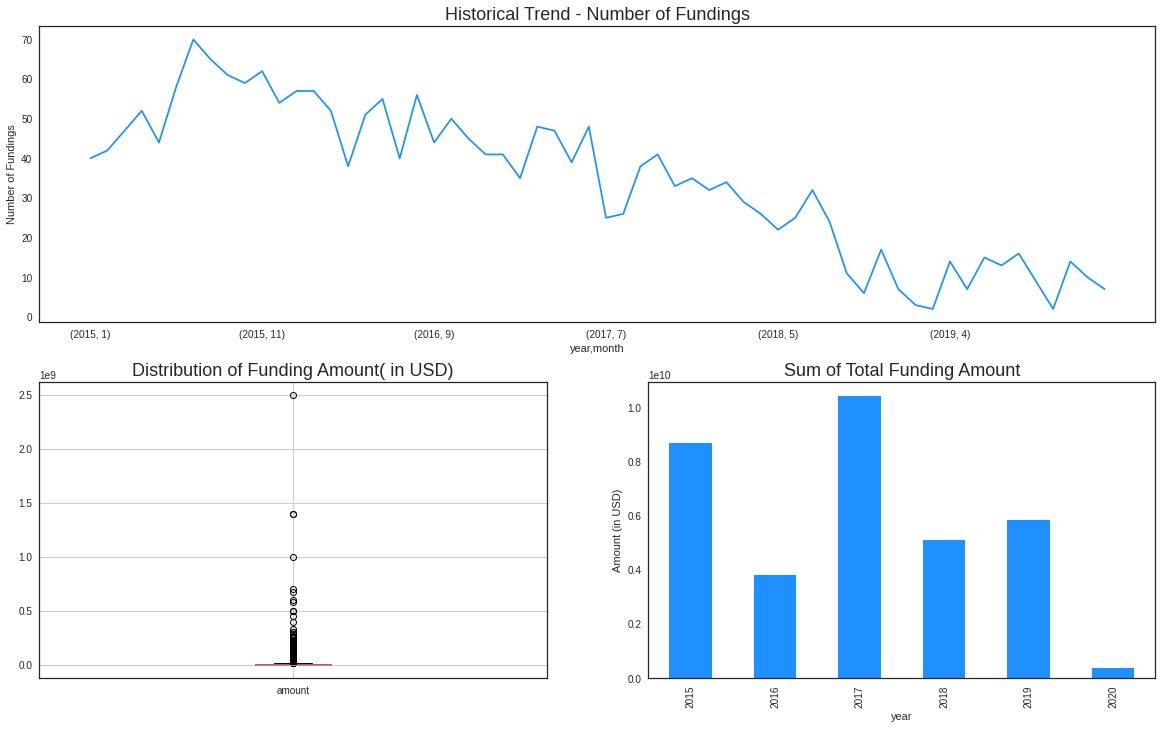

In [57]:
fig = plt.figure(figsize=(20,12))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(224)
ax3 = fig.add_subplot(223)

#trend of number of fundings
startup.groupby(['year','month']).agg(['count'])['amount'].plot(
    
    color="#1E90FF", 
    legend=False, 
    grid=False,
    ax=ax1)
ax1.set_title('Historical Trend - Number of Fundings',fontsize=18)
ax1.set_ylabel('Number of Fundings')

#Total sum of funding amount per year
startup.groupby(['year']).agg(['sum'])['amount'].plot(
    
    kind='bar',
    color="#1E90FF",
    grid=False,
    legend=False,
    ax=ax2)
ax2.set_title('Sum of Total Funding Amount',fontsize=18)
ax2.set_ylabel('Amount (in USD)');

#Boxplot Distribution of funding amount 
startup[startup['amount'] != -999].boxplot(column='amount', ax=ax3)
ax3.set_title('Distribution of Funding Amount( in USD)',fontsize=18)

plt.show();

There is clear decline in number of fundings in last few years but there is some improvement in last couple of months

1. While 2016 had the most number of fundings, 2017 saw highest total funding recieved by indian startups ( Flipkart and PayTM recieved the highest funding amount as seen earlier).
2. Total funding decreased sharply in 2018 but it's increasing steadily. 
3. Also, There are few outlier startups with a very high funding amount

# Evaluate Industry  

In [58]:
#Number of fundings per industry
startup['industry'].value_counts()[:10].sort_values(ascending=True)



Education             24
E-Commerce            29
Logistics             32
ECommerce             61
Fice                  62
Healthcare            70
-999                 171
eCommerce            186
Technology           478
Consumer Internet    941
Name: industry, dtype: int64

We see that E-Commerce has been written in different ways - eCommerce, ECommerce etc. Let's combine all of them together as 'E-commerce'

In [59]:
startup['industry'] = startup['industry'].apply(lambda x: str(x).replace("eCommerce","E-commerce").replace( "ECommerce","E-commerce").replace("E-Commerce","E-commerce"))
startup['industry'].value_counts()[:10].sort_values(ascending=True)

Ed-Tech               14
Food & Beverage       23
Education             24
Logistics             32
Fice                  62
Healthcare            70
-999                 171
E-commerce           288
Technology           478
Consumer Internet    941
Name: industry, dtype: int64

It's interesting to see that Consumer Internet saw the maximum number of Funding, followed by Technology and E-commerce.

In [60]:
#Total Sum of Fundings by Industry
startup.groupby('industry')['amount'].agg(['sum']).sort_values(by='sum', ascending=False)[:10]

,sum
industry,
E-commerce,7.978356e+09
Consumer Internet,6.253084e+09
Technology,2.229708e+09
Fice,1.971438e+09
-999,1.231811e+09
FinTech,1.220711e+09
Online Marketplace,7.001430e+08
E-commerce & M-Commerce platform,6.800000e+08
B2B,5.870000e+08


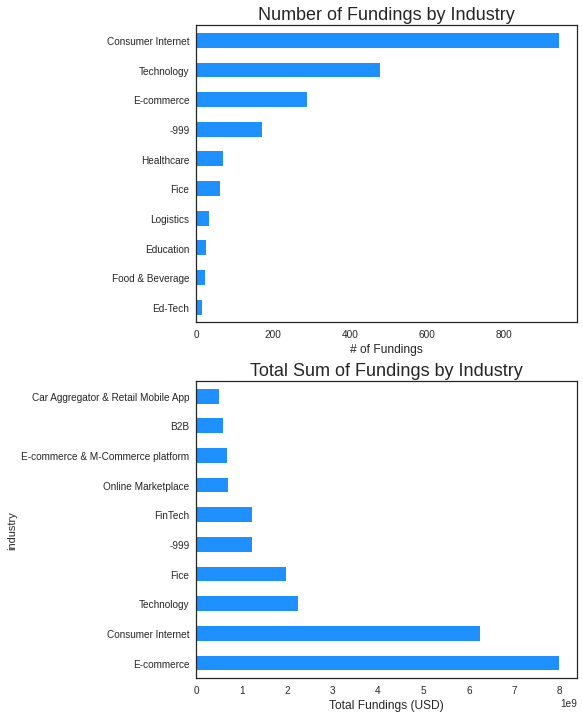

In [61]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.style.use('seaborn-notebook')

plt.style.use('seaborn-white')
fig = plt.figure(figsize=(15,12))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(223)

startup['industry'].value_counts()[:10].sort_values(ascending=True).plot(
    
    kind='barh',
    color="#1E90FF",
    grid=False,
    legend=False,
    ax=ax1)
ax1.set_title('Number of Fundings by Industry',fontsize=18)
ax1.set_xlabel('# of Fundings', fontsize=12)
startup.groupby('industry')['amount'].agg(['sum']).sort_values(by='sum', ascending=False)[:10].sort_values(by='sum', ascending=False).plot(
    kind='barh',
    color="#1E90FF", 
    legend=False, 
    grid=False,
    ax=ax2)
ax2.set_xlabel('Total Fundings (USD)', fontsize=12)
ax2.set_title('Total Sum of Fundings by Industry',fontsize=18)

plt.show();

We can see here that, even though Consumer Internet got the highest number of fundings, E-commerce industry saw the highest total funding amount. We can dig down more and see which E-commerce startups got the highest funding amount

In [62]:
#Top 5 startups in Ecommerce Industry who got the highest funding amount
startup[startup['industry']=='E-commerce'].sort_values(by='amount',ascending=False)[:5].loc[:,['startup','investor','amount','year']]

,startup,investor,amount,year
651,Flipkart,Softbank,2.500000e+09,2017
830,Paytm,SoftBank Group,1.400000e+09,2017
966,Flipkart,Microsoft eBay Tencent Holdings,1.400000e+09,2017
16,Lenskart.com,SoftBank Vision Fund,2.310000e+08,2019
27,Digital Mall Asia,Amour Infrastructure,2.200000e+08,2019


We can see a few similarities between the top funded E-commerce Startups:
1. Softbank is the investor in 3 of these startups
2. The top 3 startups are all present in Bangalore - suggesting that location might play an important role in getting funded. 

I am also interested to see the startups in Consumer Internet sector that have recieved high amount of funding. 

In [63]:
#Top 5 startups in Consumer Internet Industry who got the highest funding amount

startup[startup['industry']=="Consumer Internet"].sort_values(by='amount',ascending=False)[:5]

,date,startup,industry,sub_vertical,location,investor,investment_type,amount,remarks,year,month
924,01/03/2017,Ola,Consumer Internet,App based cab aggregator,Bangalore,SoftBank Group Corp,Private Equity,330000000.0,-999,2017,3
350,01/02/2018,BigBasket,Consumer Internet,Online Grocery & Food Store,Bengaluru,Alibaba Helion Venture Partners Bessemer Ventu...,Private Equity,300000000.0,-999,2018,2
889,14/04/2017,Ola Cabs,Consumer Internet,Cab Aggregator App,Bangalore,SIMI Pacific Pte,Private Equity,260000000.0,-999,2017,4
586,07/09/2017,OYO Rooms,Consumer Internet,Branded budget hotels marketplace,Gurgaon,SoftBank Group Sequoia Capital India Lightspee...,Private Equity,250000000.0,-999,2017,9
906,24/04/2017,Oyo Rooms,Consumer Internet,Branded Budget Hotels Aggregator,Gurgaon,SoftBank Vision Fund Lightspeed Venture Partne...,Private Equity,250000000.0,-999,2017,4


1. Again Softbank has invested in 3 of these startups
2. Also, the top 3 startups are again present in Bangalore ( also spelled as Bengaluru - we can correct it). 
3. All top 5 startups have recieved Private Equity type investment - suggesting that private equities investments are generally higher than Seed fundings.

# Evaluate Location 

In [64]:
#correct different spellings of Bengaluru
startup['location'] = startup['location'].apply(lambda x: str(x).replace("Bangalore","Bengaluru"))

#number of fundings recieved by location 
startup['location'].value_counts()[:10].sort_values(ascending=False)

Bengaluru    842
Mumbai       568
New Delhi    424
Gurgaon      291
-999         180
Pune         105
Hyderabad     99
Chennai       97
Noida         93
Gurugram      50
Name: location, dtype: int64

Bengaluru seems the top choice for startups and investors in India. But has it always been so? 

In [65]:
#Let's look at the historical trend of our top 6 states
temp_df = startup.groupby(["location","year"])["amount"].agg([sum]).reset_index()
cities_to_use = ["Bengaluru", "New Delhi", "Mumbai", "Chennai", "Pune", "Hyderabad"]
temp_df = temp_df[temp_df["location"].isin(cities_to_use)]
temp_df.columns = ["location", "year", "sum"]
temp_df[:10]                                  


,location,year,sum
13,Bengaluru,2015,2.967388e+09
14,Bengaluru,2016,1.023396e+09
15,Bengaluru,2017,7.416604e+09
16,Bengaluru,2018,1.550715e+09
17,Bengaluru,2019,1.465947e+09
18,Bengaluru,2020,2.183589e+08
40,Chennai,2015,2.419000e+08
41,Chennai,2016,1.167550e+08
42,Chennai,2017,1.038230e+08
43,Chennai,2018,2.422890e+08


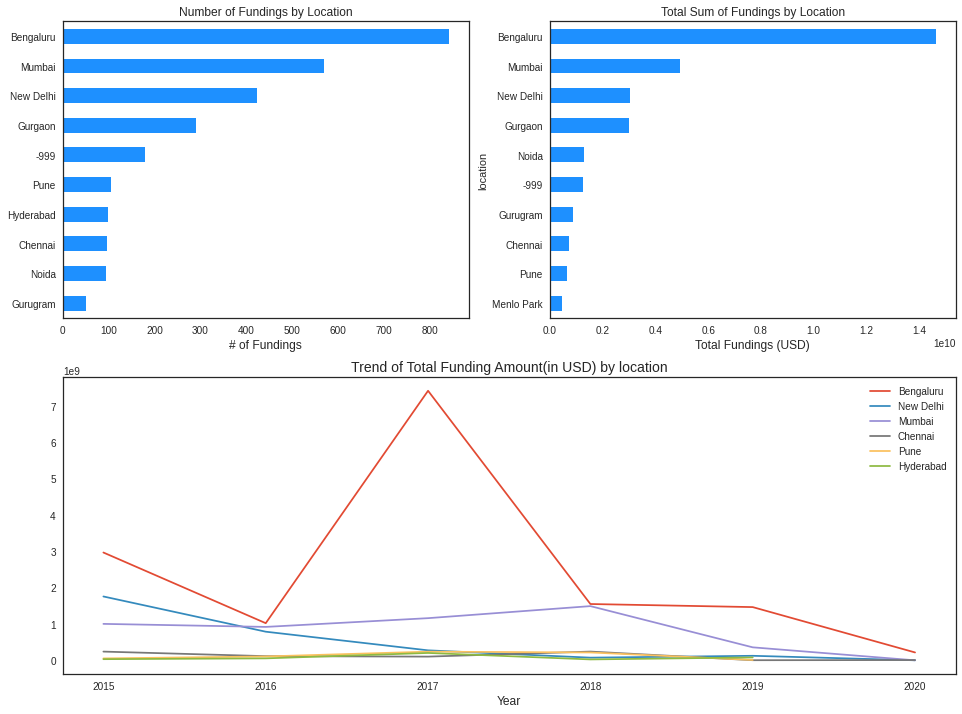

In [66]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.style.use('seaborn-notebook')

plt.style.use('seaborn-white')
fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

cmap = plt.cm.coolwarm_r

startup['location'].value_counts()[:10].sort_values().plot(
    kind='barh',
    color="#1E90FF",
    title='Number of Fundings by Location',
    grid=False,
    legend=False,
    ax=ax1)
ax1.set_xlabel('# of Fundings', fontsize=12)
startup.groupby(['location'])['amount'].agg(sum).sort_values(ascending=False)[:10].sort_values(ascending=True).plot(
    kind='barh',
    color="#1E90FF", 
    title='Total Sum of Fundings by Location', 
    legend=False, 
    grid=False,
    ax=ax2)
ax2.set_xlabel('Total Fundings (USD)', fontsize=12)

for loc in cities_to_use:
    df =  temp_df[temp_df['location']==loc]
    df.plot(x='year', y='sum', kind='line',label=loc, ax = ax3)

ax3.legend()    
ax3.set_title('Trend of Total Funding Amount(in USD) by location', fontsize=14)
ax3.set_xlabel('Year', fontsize=12)
plt.show();

Bengaluru is way ahead in terms of total funding amount recieved. We can also evaluate the historical trend and see whether it was always investors and startup owners top choice

We can see a general decreasing trend at all locations. Bengaluru stills tops the charts in the total number of fundings recieved by indian startups

1. Bengaluru has been the top state in term of total funding amount since 2015. 
2. Mumbai surpassed New Delhi in 2016 and is still at #2 position 
3. Bengaluru saw a huge spike in 2017 - from our earlier visualization, we saw startups like Flipkart, PayTM recived a billion dollars fundings in 2017 

It would be interesting to see the most common type of fundings received by Indian startups. 

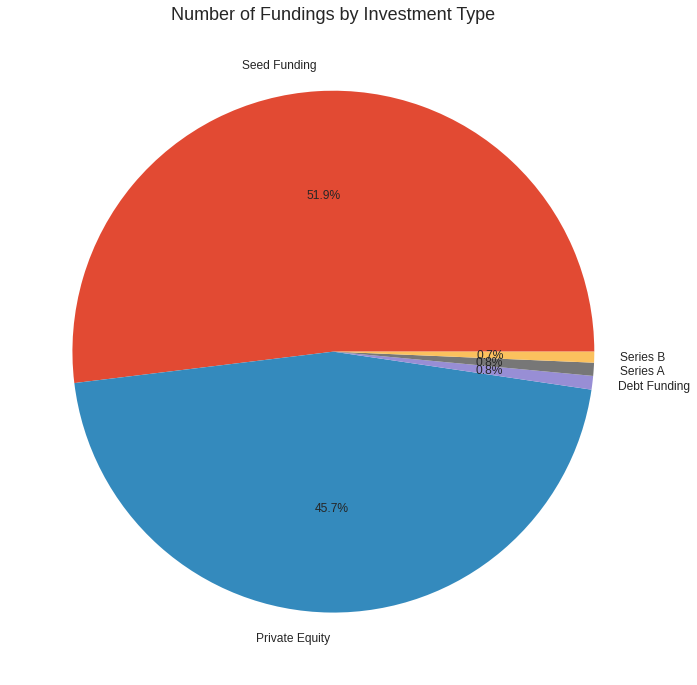

In [67]:
#Correct 'Seed/Angel Funding' as 'Seed Funding' 
startup['investment_type'] = startup['investment_type'].apply(lambda x: 'Seed Funding' if 'Seed' in str(x) else x)

#Number of fundings by investent type 
startup['investment_type'].value_counts()[:5].plot(figsize=(12,12),kind='pie', legend=False,fontsize=12,autopct='%1.1f%%')
plt.title( 'Number of Fundings by Investment Type', fontsize=18)
plt.ylabel("");


Private Equity and Seed Funding Form are most common type of investments made in Indians Startups